# Annual Mean Temperature Distribution
This looks at how surface temperature develops with time throughout the year

In [2]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier, gamma_linear_approx, swdn_from_temp_fourier
from isca_tools.thesis.hottest_date import get_var_extrema_date
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [3]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'drag_q', 'q_surf', 'rho', 'p_atm', 'ps', 'q_surf']  
# Load dataset
tau_lw = [1]
n_exp = len(tau_lw)
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'
exp_dir = 'aquaplanet/no_wishe/'
# exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
exp_name = [f"k={str(tau_lw[i]).replace('.','_')}_no_conv" for i in range(n_exp)]

# exp_dir = 'rossbypalooza/variable_evap_flux/evap=0/'
# exp_name=''

lat_range = slice(20, 90)               # only consider NH and outside deep tropics
use_time_start = 360*2
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_base += [ds_use.sel(time=slice(use_time_start, np.inf)).sel(lat=lat_range)]      # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]
w_atm_const = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['w_atm_const']
p_surface_approx = isca_tools.load_namelist(exp_dir+exp_name[0])['spectral_dynamics_nml']['reference_sea_level_press']/100

100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

Removing height from var_keep


In [4]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [5]:
ds = ds_base[0].sel(pfull=p_surface_approx, method='nearest')
p_surface = float(ds.pfull)*100
sigma_near_surf = float(ds.pfull/p_surface_approx)
ds['rh'] = ds.sphum / sphum_sat(ds.temp, p_surface)
ds = annual_mean(ds).mean(dim='lon')
ds = ds.assign_coords(time=(ds.time - ds.time.min()).astype(int)).load()

In [6]:
# Make every thing dependent on surface temperature (NOT NEAR-SURFACE) as equation easier to solve
# Link to near-surface with T_{s-a} term in latent flux etc
n_lat = ds.lat.size
n_time = ds.time.size
t_surf = ds.t_surf.to_numpy().transpose()
t_surf_anom = t_surf - np.mean(t_surf, axis=1)[:, np.newaxis]
t_surf_spline_fit = [scipy.interpolate.CubicSpline(np.append(ds.time.to_numpy(), ds.time[-1]+1), 
                                                       np.append(t_surf[i], t_surf[i, 0]), bc_type='periodic') for i in range(n_lat)]
# t_surf_anom_spline_fit = scipy.interpolate.CubicSpline(np.append(ds.time.to_numpy(), ds.time[-1]+1), 
#                                                        np.append(t_surf_anom, t_surf_anom[0]), bc_type='periodic')

def linear_func(x_var, a, b):
    return a + b*x_var

def square_func(x_var, a, b, c):
    # Subtract mean of squared anomaly so c does not influence value of a and b.
    x_anom_squared = (x_var-np.mean(x_var))**2
    return a + b*x_var + c*(x_anom_squared - np.mean(x_anom_squared))

def quartic_func(x_var, a, b, c, d, e):
    # Subtract mean of squared anomaly so c does not influence value of a and b.
    x_anom_cubed = (x_var-np.mean(x_var))**3
    x_anom_fourth_power = (x_var-np.mean(x_var))**4
    return square_func(x_var, a, b, c) + d*(x_anom_cubed - np.mean(x_anom_cubed)) + \
        e*(x_anom_fourth_power-np.mean(x_anom_fourth_power))

def linear_func_shift(time, a, b, c, spline):
    x_var_shift = spline(time-c)
    return a + b*x_var_shift

## Obtaining Estimate of Amplitude and Phase of Actual Temperature Profile
Below, I smooth the temperature profile with a window of 20 days, and take the phase and amplitude of extrema from the resultant smoothed profile. These are indicated by the grey vertical lines, and differ slightly from the actual maxima and minima shown by the black solid lines.

I record the phase, as indicated by $\delta$, relative to the 1st harmonic of the insolation (shown by thick grey lines on left).

Below the example for a specific latitude, I plot the phase, $\delta$, and amplitude, $|T|$ for all latitudes. These are the values which we want to replicate, with a theoretical value.

In [32]:
sw_amp_coefs = {key: np.zeros((n_lat, 1+int(key))) for key in ['1', '2']}
sw_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1', '2']}
for i in range(n_lat):
    for key in sw_amp_coefs:
        sw_amp_coefs[key][i] = fourier.get_fourier_fit(ds.time, ds.swdn_sfc[:, i], n_time, int(key))[1]
        # Fit SW fourier with no phase
        sw_fourier_fit[key][i] = fourier.fourier_series(ds.time, n_time, sw_amp_coefs[key][i], np.zeros(int(key)))
# Record phase of maxima / minima relative to extrema times of 1st harmonic of SW radiation 
time_extrema_sw = {'min': int(ds.time[0]), 'max': int(ds.time[int(ds.time.size/2)])}
time_extrema_temp = {key: {'simulated': np.zeros(n_lat)} for key in ['min', 'max']}
amp_extrema_temp = {key: {'simulated': np.zeros(n_lat)} for key in ['min', 'max']}

smooth_ndays_temp_extrema = 20            # smoothing to temp annual mean to find date of hottest day
for i in range(n_lat):
    for key in time_extrema_temp:
        time_extrema_temp[key]['simulated'][i], spline_use = get_var_extrema_date(ds.time, t_surf_anom[i], smooth_window=smooth_ndays_temp_extrema, 
                                                                     type=key, max_extrema=1)
        amp_extrema_temp[key]['simulated'][i] = np.abs(spline_use(time_extrema_temp[key]['simulated'][i]))

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_86090/1660199413.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_extrema_temp[key]['simulated'][i], spline_use = get_var_extrema_date(ds.time, t_surf_anom[i], smooth_window=smooth_ndays_temp_extrema,


In [637]:
# General plotting info

plot_lat_ind = 0
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_time = [ds.time[0]-1, ds.time[-1]+1]
ax_lims_lat = [np.floor(ds.lat[0]), 90]
color_approx = {'linear': 'k', 'quartic': default_colors[3], '1_harmonic': default_colors[1], 'linear_approx': 'k', 
                'linear_shift': default_colors[0], 'linear_shift_0phase': 'k', 'linear_shift_approx': default_colors[0]}
color_extrema = {'max': default_colors[3], 'min': default_colors[0]}
linestyle_approx = {'linear': ':', 'quartic': ':', '1_harmonic': '-', 'linear_shift': '-', 'linear_shift_0phase': ':', 'linear_shift_approx': ':'}

# Define error func to use
error_func_dict = {'max': lambda x, x_approx: np.max(np.abs(x - x_approx), axis=1), 
                   'median': lambda x, x_approx: np.median(np.abs(x - x_approx), axis=1), 
                   'mean': lambda x, x_approx: np.mean(np.abs(x - x_approx), axis=1)}
error_func_use = 'median'
error_func = error_func_dict[error_func_use.lower()]

# Whether to show plots with smoothing of simulated values done or not. Theoretical curves always shown without smoothing
# Will also smooth simulated var but not approximated var before calculating error
# Fitting is always done with no smoothing performed first.
plot_smooth = True
if plot_smooth:
    smooth_func = lambda x, ax=-1: scipy.ndimage.convolve1d(x, np.ones(smooth_ndays_temp_extrema)/smooth_ndays_temp_extrema, mode='wrap', axis=ax)
else:
    smooth_func = lambda x, ax: x

In [144]:
fig_sw_temp_sl, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax[0].plot(ds.time, ds.swdn_sfc[:, plot_lat_ind], color='k', label='Simulated')
ax[0].plot(ds.time, sw_fourier_fit['2'][plot_lat_ind], color='grey', 
           alpha=0.5, lw=2.5, label='2 Harmonics')

ax[1].plot(ds.time, smooth_func(t_surf_anom[plot_lat_ind]), color='k', label='Simulated')
for key in time_extrema_sw:
    ax[0].scatter(time_extrema_sw[key], ds.swdn_sfc.sel(time=time_extrema_sw[key])[plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
    ax[1].scatter(time_extrema_temp[key]['simulated'][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key]['simulated'][plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
    
ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*month_ticks)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_ylim(-np.abs(ax[1].get_ylim()).max(), np.abs(ax[1].get_ylim()).max())
ax[0].set_ylabel('$SW^{\\downarrow}$ [Wm$^{-2}$]')
ax[1].set_ylabel('$T - \overline{T}$ [K]')
ax[0].legend()
ax[1].legend()
fig_sw_temp_sl.suptitle(f"Lat = ${int(ds.lat[plot_lat_ind])}\degree$; "
             f"$\delta_{'{min}'}$={round(time_extrema_temp['min']['simulated'][plot_lat_ind]-time_extrema_sw['min'], 1)}; "
             f"$\delta_{'{max}'}$={round(time_extrema_temp['max']['simulated'][plot_lat_ind]-time_extrema_sw['max'], 1)} days", fontsize=8, y=0.93)
plt.close()

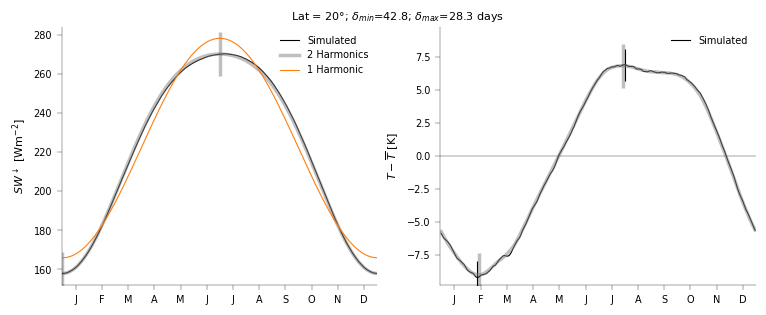

In [158]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)

ax[1].lines[0].set_ydata(t_surf_anom[plot_lat_ind])         # change y values of black line so actual not smoothed line
ax[1].plot(ds.time, scipy.ndimage.convolve1d(t_surf_anom[plot_lat_ind], np.ones(smooth_ndays_temp_extrema)/smooth_ndays_temp_extrema, 
                                             mode='wrap'), color='grey', lw=2.5, alpha=0.5)
ax[0].plot(ds.time, sw_fourier_fit['1'][plot_lat_ind], color=color_approx['1_harmonic'],
           linestyle=linestyle_approx['1_harmonic'], label='1 Harmonic')
ax[1].scatter(ds.time[t_surf_anom[plot_lat_ind].argmin()], t_surf_anom[plot_lat_ind].min(),
                   color='k', marker='|', s=500)
ax[1].scatter(ds.time[t_surf_anom[plot_lat_ind].argmax()], t_surf_anom[plot_lat_ind].max(),
                   color='k', marker='|', s=500)
ax[0].legend()
fig

Text(0.5, 0.05, 'Latitude [deg]')

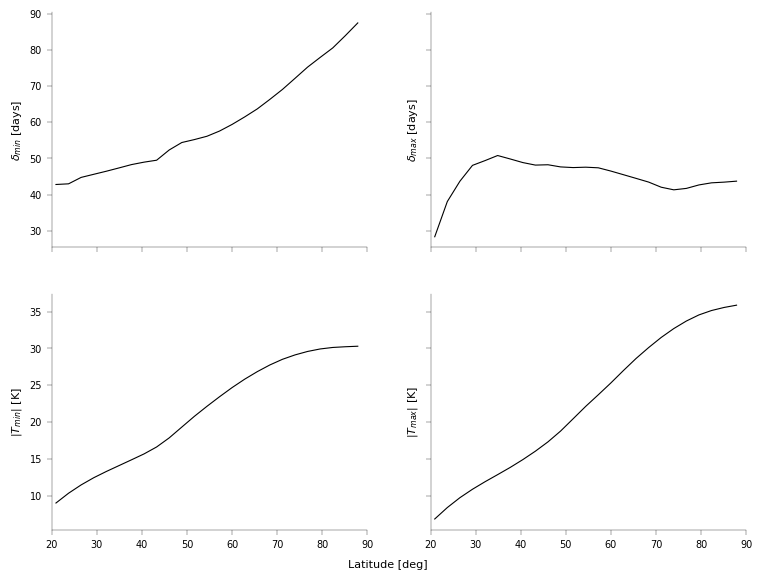

In [65]:
fig_extrema, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for i, key in enumerate(time_extrema_temp):
    ax[0, i].plot(ds.lat, time_extrema_temp[key]['simulated'] - time_extrema_sw[key], color='k', label='Simulated')
    ax[1, i].plot(ds.lat, amp_extrema_temp[key]['simulated'], color='k')
    ax[0, i].set_ylabel(f"$\delta_{'{'+key+'}'}$ [days]")
    ax[1, i].set_ylabel(f"$|T_{'{'+key+'}'}|$ [K]")
ax[0, 0].set_xlim(ax_lims_lat)
fig_extrema.supxlabel('Latitude [deg]', fontsize=8, y=0.05)

## Linear Surface Budget
The surface energy budget is $C\frac{\partial T}{\partial t} = SW^{\downarrow} - (LW^{\uparrow} - LW^{\downarrow}) - LH^{\uparrow} - SH^{\uparrow}$
 
As we saw above, a Fourier representation, $SW^{\downarrow}(t) \approx F_0 + F_1\cos(2\pi ft) + \frac{F_2}{F_1}F_1\cos(4\pi ft)$ works well (second term is only included if there are two harmonics).

Given this, if we can represent $\Gamma^{\uparrow}(t) = (LW^{\uparrow} - LW^{\downarrow}) + LH^{\uparrow} + SH^{\uparrow} \approx \lambda_0 + \lambda T(t)$, then a Fourier solution for $T(t)$ with the same number of harmonics as $SW^{\downarrow}$ is possible:

$T(t) = \frac{T_0}{2} + \sum_{n=1}^{N} T_n\cos(2n\pi ft - \phi_n)$

Below, we look at how accurate this approximation is.

A comparison to the *best* possible approximation with just temperature is shown, via the quartic approximation:

$\Gamma^{\uparrow}(t) \approx \lambda_0 + \lambda_1 T(t) + \lambda_2 (T'^2 - \overline{T'^2}) + \lambda_3 (T'^3 - \overline{T'^3}) + 
\lambda_4(T'^4 - \overline{T'^4})$

where $T' = T-\overline{T}$ is the temperature anomaly.

In [11]:
gamma_up = np.asarray(ds.lwup_sfc - ds.lwdn_sfc + ds.flux_lhe + ds.flux_t).transpose()
gamma_params = {'linear': np.zeros((n_lat, 2)), 'quartic': np.zeros((n_lat, 5))}
gamma_approx = {'linear': np.zeros((n_lat, n_time)), 'quartic': np.zeros((n_lat, n_time))}
gamma_params0 = [-800, 4]
for i in range(n_lat):
    gamma_params['linear'][i] = optimize.curve_fit(linear_func, t_surf[i], gamma_up[i], p0=gamma_params0)[0]
    gamma_params['quartic'][i] = optimize.curve_fit(quartic_func, t_surf[i], gamma_up[i], p0=gamma_params0 + [0, 0, 0])[0]
    gamma_approx['linear'][i] = linear_func(t_surf[i], *gamma_params['linear'][i])
    gamma_approx['quartic'][i] = quartic_func(t_surf[i], *gamma_params['quartic'][i])

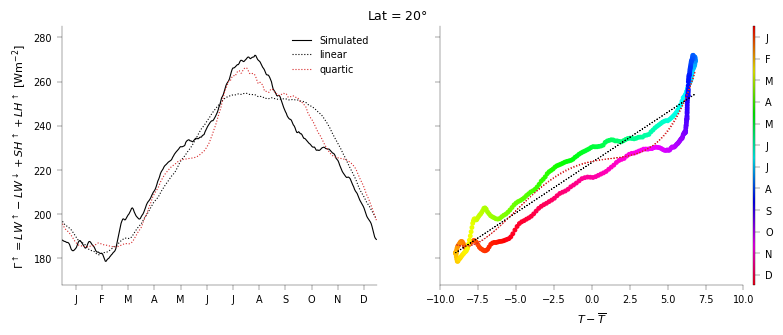

In [150]:
fig, ax = plt.subplots(1,2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharey=True)
ax[0].plot(ds.time, smooth_func(gamma_up[plot_lat_ind]), color='k', label='Simulated')
im = ax[1].scatter(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(gamma_up[plot_lat_ind]), c=ds.time, cmap='hsv')
for key in ['linear', 'quartic']:
    ax[0].plot(ds.time, gamma_approx[key][plot_lat_ind], 
               color=color_approx[key], linestyle=linestyle_approx[key], label=key.lower())
    ax[1].plot(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(gamma_approx[key][plot_lat_ind]), 
               color=color_approx[key], linestyle=linestyle_approx[key], label=key.lower())

cbar = fig.colorbar(im, ax=ax[1], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax[0].set_ylabel('$\Gamma^{\\uparrow} = LW^{\\uparrow} - LW^{\\downarrow} + SH^{\\uparrow} + LH^{\\uparrow}$ [Wm$^{-2}$]')
ax[1].set_xlabel('$T - \overline{T}$')
ax[1].set_xlim(-np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()), np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()))
ax[1].set_ylim(np.floor(gamma_up[plot_lat_ind].min()), np.ceil(gamma_up[plot_lat_ind].max()))
ax[0].legend()
ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
fig.suptitle(f"Lat = ${int(ds.lat[plot_lat_ind])}\degree$", fontsize=9, y=0.93);

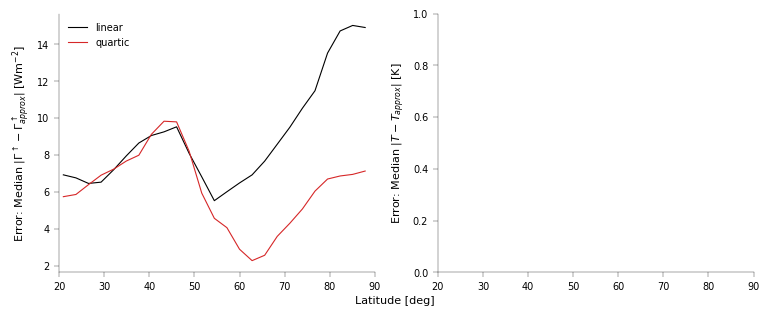

In [201]:
fig_error, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for key in ['linear', 'quartic']:
    ax[0].plot(ds.lat, error_func(smooth_func(gamma_up), gamma_approx[key]), color=color_approx[key],
               label=key)
ax[0].legend()
ax[0].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|\Gamma^{\\uparrow} - \Gamma^{\\uparrow}_{approx}|$ [Wm$^{-2}$]')
ax[1].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [K]')
ax[0].set_xlim(ax_lims_lat)
fig_error.supxlabel('Latitude [deg]', fontsize=8);

### Problem with 1 Harmonic

Below we see that with 1 harmonic, the phasing and amplitude of the maxima and minima are constrained to be the same. But clearly we do not see this in the actual data.

As a comparison, I include a numerical solution obtained with a quartic approximation for $\Gamma^{\uparrow}$ and with 5 harmonics of temperature as an indicator of the *best* we can possibly do.

Allowing for two harmonics, with this linear $\Gamma$ approximation does almost as well as the quartic approximation in terms of the phasing and amplitude of the maxima. It not allows for asymmetry.

In [175]:
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth[0])
quartic_n_harmonics = 5
temp_approx = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', 'quartic', 'linear']}
for i in tqdm(range(n_lat)):
    temp_approx['1_harmonic'][i] = get_temp_fourier(ds.time, sw_fourier_fit['1'][i], heat_capacity, gamma_params['linear'][i], n_harmonics=1)[0]
    temp_approx['linear'][i] = get_temp_fourier(ds.time, sw_fourier_fit['2'][i], heat_capacity, gamma_params['linear'][i])[0]
    # For quartic allow 5 harmonic for temperature, but use 2 harmonic SW approximation, to allow more direct comparison
    temp_approx['quartic'][i] = get_temp_fourier(ds.time, sw_fourier_fit['2'][i], heat_capacity, gamma_params['quartic'][i][:2], 
                                                 lambda_nl=gamma_params['quartic'][i][2:], numerical=True, n_harmonics=quartic_n_harmonics)[0]
    
for key in temp_approx:
    time_extrema_temp['min'][key] = ds.time[temp_approx[key].argmin(axis=1)].to_numpy()
    time_extrema_temp['max'][key] = ds.time[temp_approx[key].argmax(axis=1)].to_numpy()
    amp_extrema_temp['min'][key] = temp_approx[key].mean(axis=1) - temp_approx[key].min(axis=1)
    amp_extrema_temp['max'][key] = temp_approx[key].max(axis=1) - temp_approx[key].mean(axis=1)

100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


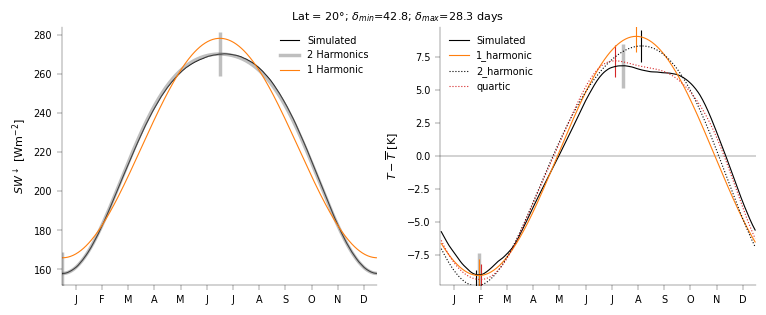

In [178]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
ax[0].plot(ds.time, sw_fourier_fit['1'][plot_lat_ind], color=color_approx['1_harmonic'],
           linestyle=linestyle_approx['1_harmonic'], label='1 Harmonic')
for key2 in ['1_harmonic', 'linear', 'quartic']:
    ax[1].plot(ds.time, temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean(), color=color_approx[key2], 
                          linestyle=linestyle_approx[key2], label=key2 if key2 != 'linear' else '2_harmonic')

for key in time_extrema_sw:
    for key2 in ['1_harmonic', 'linear', 'quartic']:
        ax[1].scatter(time_extrema_temp[key][key2][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key][key2][plot_lat_ind],
                           color=color_approx[key2], marker='|', s=500)
ax[0].legend()
ax[1].legend()
fig

### Theory for Amplitude and Phasing
We know the single harmonic analytic solution has an issue that the phasing and amplitude of maxima and minima are forced to be the same.

The analytic two harmonic solution on the other hand, overcomes this problem. A relatively simple equation can be derived for the phasing and amplitude of the second harmonic assuming the extrema are near the extrema of the first harmonic. This is shown by the crosses below, and qualitatively explains why at high latitudes, the minima (maxima) occur later (earlier) than predicted from the first harmonic, 
and the amplitude is less (more) than that of the 1st harmonic.

This assumes $|4\pi f\Delta| << 1$, where $\Delta$ is the time difference between 1 harmonic and 2 harmonic maxima. Thus it breaks down at high latitudes for the minima, where $\Delta > 20$ days.

In [670]:
day_seconds = 86400
def get_extrema_amp_time_approx(sw_amp1, sw_amp2, lambda_const, heat_capacity, lambda_r=0, Lambda_r=0, 
                                type='max', n_day_year=360, day_seconds: float = day_seconds):
    f = 1/(n_day_year*day_seconds)
    heat_capacity = heat_capacity - lambda_r * Lambda_r*day_seconds
    lambda_tot = lambda_const + lambda_r - 2 * np.pi**2 * lambda_r * (Lambda_r/n_day_year)**2
    
    x = 2*np.pi*f*heat_capacity/lambda_tot
    
    a = sw_amp1/lambda_tot/np.sqrt(1+x**2)
    b = sw_amp2/lambda_tot/(1+x**2)/(1+4*x**2)
    ba_ratio = b/a

    
    if (sw_amp1>0 and type.lower() == 'max') or (sw_amp1<0 and type.lower() == 'min'):
        t_extrema1 = np.arctan(x)/(2*np.pi*f)               # timing of 1st harmonic extrema
        # modification to extrema from 1st harmonic for 2 harmonics
        t_extrema_mod = -2 * x**3 * ba_ratio / (1+4*ba_ratio + 12*ba_ratio*x**2) / (np.pi*f)  
        # t_extrema_mod = np.clip(t_extrema_mod, 0, 30*day_seconds)
        amp_extrema1 = a
        # sclae factor to multiply amp_extrema1 to get modified extrema amplitude with 2 harmonics
        amp_extrema_scale = 1 + ba_ratio * (1+3*x**2) - 4*x**3*ba_ratio*np.pi*f*t_extrema_mod   
    else:
        t_extrema1 = (np.arctan(x)+np.pi)/(2*np.pi*f)               # timing of 1st harmonic extrema
        t_extrema_mod = 2 * x**3 * ba_ratio / (1-4*ba_ratio - 12*ba_ratio*x**2) / (np.pi*f)  
        amp_extrema1 = -a
        amp_extrema_scale = 1 - ba_ratio * (1+3*x**2) + 4*x**3*ba_ratio*np.pi*f*t_extrema_mod
    t_extrema1 = t_extrema1/day_seconds
    t_extrema_mod = t_extrema_mod/day_seconds
    info_dict = {'t_extrema1': t_extrema1, 't_extrema_mod': t_extrema_mod, 'amp_extrema1': amp_extrema1, 'amp_extrema_scale': amp_extrema_scale}
    return t_extrema1+t_extrema_mod, amp_extrema1 * amp_extrema_scale, info_dict

for key in time_extrema_temp:
    time_extrema_temp[key]['linear_taylor_calc'] = np.zeros(n_lat)
    amp_extrema_temp[key]['linear_taylor_calc'] = np.zeros(n_lat)
    for i in range(n_lat):
        time_extrema_temp[key]['linear_taylor_calc'][i], amp_extrema_temp[key]['linear_taylor_calc'][i] = \
            get_extrema_amp_time_approx(*sw_amp_coefs['2'][i, 1:], gamma_params['linear'][i][1], heat_capacity, type=key)[:2]
amp_extrema_temp['min']['linear_taylor_calc'] = np.abs(amp_extrema_temp['min']['linear_taylor_calc'])
# plt.plot(ds.lat, amp_extrema_temp['min']['1_harmonic'], color=default_colors[1])   
# plt.plot(ds.lat, amp_extrema_temp['min']['linear'], color='k')    

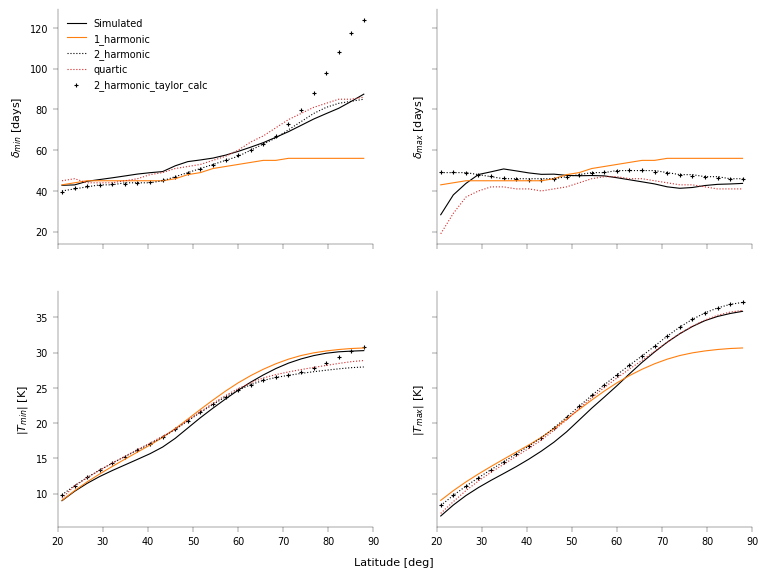

In [659]:
fig = copy.deepcopy(fig_extrema)
ax = np.asarray(fig.axes).reshape(2, 2)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['1_harmonic', 'linear', 'quartic']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2], label=key2 if key2 != 'linear' else '2_harmonic')
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2])
    ax[0, i].scatter(ds.lat, time_extrema_temp[key]['linear_taylor_calc'] - time_extrema_sw[key], color=color_approx['linear'], marker='+',
                     label='2_harmonic_taylor_calc')
    ax[1, i].scatter(ds.lat, amp_extrema_temp[key]['linear_taylor_calc'], color=color_approx['linear'], marker='+')
ax[0, 0].legend()
fig

## Extension beyond 2 Harmonics
Below, we see that the 2 harmonic analytic solution for $T$ with linear $\Gamma^{\uparrow}$ is almost as good as the quartic solution. It is significantly worse at latitudes where the approximation for $\Gamma^{\uparrow}$ itself breaks down. 

So, to further improve our temperature theory, we need a better approximation for $\Gamma^{\uparrow}$.

The blue line includes a phase shift for relative humidity, and is clearly important for low latitudes.

In [502]:
lh_rh_prefactor = -L_v * w_atm_const * ds.drag_q.mean(dim='time') * get_density(ds.temp.mean(dim='time'), ds.pfull*100) * \
                  sphum_sat(ds.temp.mean(dim='time'), ds.pfull*100)
lh_rh_cont = lh_rh_prefactor * (ds.rh - ds.rh.mean(dim='time'))
lh_rh_cont_params = np.zeros((n_lat, 3))
gamma_params['linear_shift'] = np.zeros((n_lat, 4))     # lambda_0, lambda, lambda_r, Lambda_r
gamma_approx['linear_shift'] = np.zeros((n_lat, n_time))
for i in range(n_lat):
    fit_func_use = lambda x, a, b, c: linear_func_shift(x, a, b, c, spline=t_surf_spline_fit[i])
    lh_rh_cont_params[i] = optimize.curve_fit(fit_func_use, ds.time, 
                                                         lh_rh_cont[i], p0=[50, -1, 0])[0]
    gamma_approx['linear_shift'][i] = linear_func_shift(ds.time, *lh_rh_cont_params[i], t_surf_spline_fit[i])
    gamma_params['linear_shift'][i, :2] = optimize.curve_fit(linear_func, t_surf[i], 
                                                         gamma_up[i] - lh_rh_cont[i], p0=gamma_params0)[0]
    gamma_approx['linear_shift'][i] = gamma_approx['linear_shift'][i] + linear_func(t_surf[i], *gamma_params['linear_shift'][i, :2])
# Add phase parameters to full lambda
gamma_params['linear_shift'][:, 0] = gamma_params['linear_shift'][:, 0] + lh_rh_cont_params[:, 0]
gamma_params['linear_shift'][:, 2:] = lh_rh_cont_params[:, 1:]

temp_approx['linear_shift'] = np.zeros((n_lat, n_time))
temp_approx['linear_shift_0phase'] = np.zeros((n_lat, n_time))          # same as lambda_shift but set phase factor to 0
for i in range(n_lat):
    temp_approx['linear_shift'][i] = get_temp_fourier(ds.time, sw_fourier_fit['2'][i], heat_capacity, gamma_params['linear_shift'][i, :3], 
                                                      np.asarray([0, gamma_params['linear_shift'][i, 3]]))[0]
    temp_approx['linear_shift_0phase'][i] = get_temp_fourier(ds.time, sw_fourier_fit['2'][i], heat_capacity, gamma_params['linear_shift'][i, :3], 
                                                      )[0]

for key2 in ['linear_shift', 'linear_shift_0phase']:
    for key in time_extrema_temp:
        time_extrema_temp[key][key2] = np.zeros(n_lat)
        amp_extrema_temp[key][key2] = np.zeros(n_lat)
    time_extrema_temp['min'][key2] = ds.time[temp_approx[key2].argmin(axis=1)].to_numpy()
    time_extrema_temp['max'][key2] = ds.time[temp_approx[key2].argmax(axis=1)].to_numpy()
    amp_extrema_temp['min'][key2] = temp_approx[key2].mean(axis=1) - temp_approx[key2].min(axis=1)
    amp_extrema_temp['max'][key2] = temp_approx[key2].max(axis=1) - temp_approx[key2].mean(axis=1)

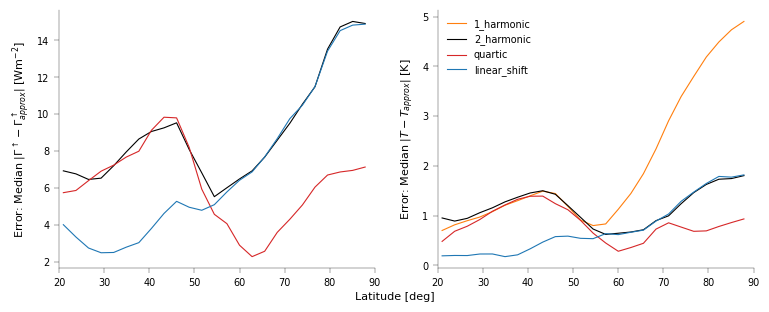

In [503]:
fig = copy.deepcopy(fig_error)
ax = fig.axes
for key in ['1_harmonic', 'linear', 'quartic', 'linear_shift']:
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_approx[key] - 
                                  np.mean(temp_approx[key], axis=1)[:, np.newaxis]), color=color_approx[key], 
               label=key if key != 'linear' else '2_harmonic')
ax[0].plot(ds.lat, error_func(smooth_func(gamma_up), gamma_approx['linear_shift']), color=color_approx['linear_shift'], 
               label=key if key != 'linear' else '2_harmonic')
ax[1].legend()
ax[0].get_legend().remove()
fig

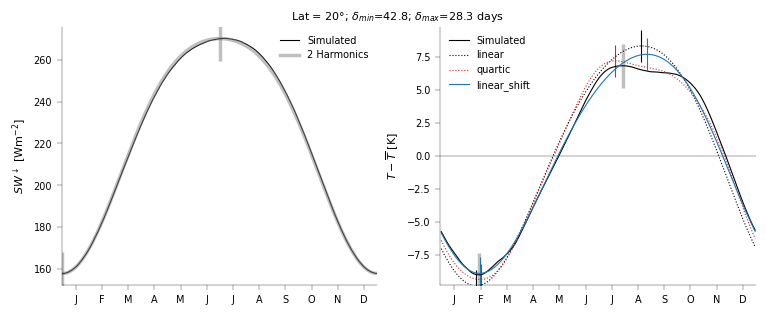

In [504]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
for key2 in ['linear', 'quartic', 'linear_shift']:
    ax[1].plot(ds.time, temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean(), color=color_approx[key2], 
                          linestyle=linestyle_approx[key2], label=key2)

for key in time_extrema_sw:
    for key2 in ['linear', 'quartic', 'linear_shift']:
        ax[1].scatter(time_extrema_temp[key][key2][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key][key2][plot_lat_ind],
                           color=color_approx[key2], marker='|', s=500)
ax[0].legend()
ax[1].legend()
fig

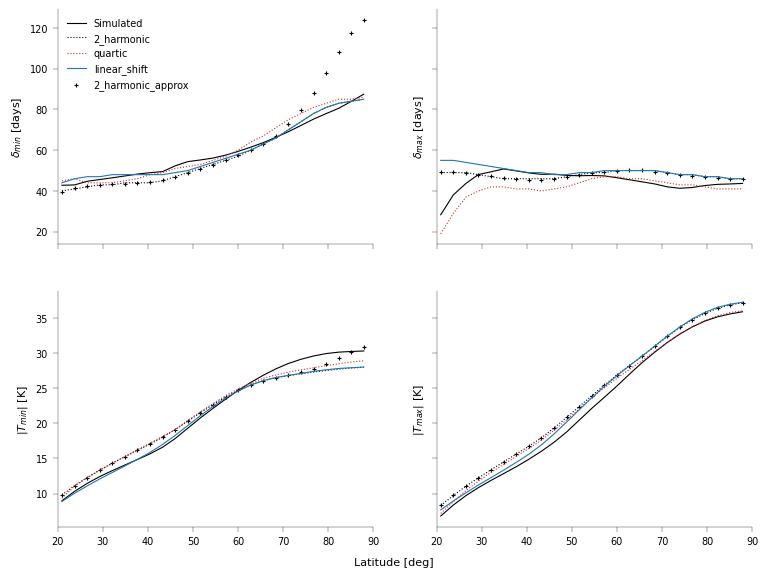

In [501]:
fig = copy.deepcopy(fig_extrema)
ax = np.asarray(fig.axes).reshape(2, 2)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['linear', 'quartic', 'linear_shift']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2], label=key2 if key2 != 'linear' else '2_harmonic')
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2])
    ax[0, i].scatter(ds.lat, time_extrema_temp[key]['linear_approx'] - time_extrema_sw[key], color=color_approx['linear'], marker='+',
                     label='2_harmonic_approx')
    ax[1, i].scatter(ds.lat, amp_extrema_temp[key]['linear_approx'], color=color_approx['linear'], marker='+')
ax[0, 0].legend()
fig

### Quantifying the effect of including phase, $\Lambda_r$

In [672]:
for key2 in ['linear_shift_approx']:
    temp_approx[key2] = np.zeros((n_lat, n_time))
    for key in time_extrema_temp:
        time_extrema_temp[key][key2] = np.zeros(n_lat)
        amp_extrema_temp[key][key2] = np.zeros(n_lat)
        time_extrema_temp[key]['linear_shift_taylor_calc'] = np.zeros(n_lat)
        amp_extrema_temp[key]['linear_shift_taylor_calc'] = np.zeros(n_lat)
        
    for i in range(n_lat):
        heat_capacity_mod = heat_capacity - gamma_params['linear_shift'][i, 2]*gamma_params['linear_shift'][i, 3]*day_seconds
        lambda_const_mod = gamma_params['linear_shift'][i][1]+gamma_params['linear_shift'][i][2] - \
                           2*np.pi**2*(gamma_params['linear_shift'][i, 3]/360)**2 * gamma_params['linear_shift'][i, 2]
        temp_approx[key2][i] = get_temp_fourier(ds.time, sw_fourier_fit['2'][i], heat_capacity_mod, 
                                                                 np.asarray([gamma_params['linear_shift'][i, 0], lambda_const_mod]))[0]
        for key in time_extrema_temp:
            time_extrema_temp[key]['linear_shift_taylor_calc'][i], amp_extrema_temp[key]['linear_shift_taylor_calc'][i] = \
                get_extrema_amp_time_approx(*sw_amp_coefs['2'][i, 1:], gamma_params['linear_shift'][i][1], heat_capacity,
                                            gamma_params['linear_shift'][i][2], gamma_params['linear_shift'][i][3], type=key)[:2]

    time_extrema_temp['min'][key2] = ds.time[temp_approx[key2].argmin(axis=1)].to_numpy()
    time_extrema_temp['max'][key2] = ds.time[temp_approx[key2].argmax(axis=1)].to_numpy()
    amp_extrema_temp['min'][key2] = temp_approx[key2].mean(axis=1) - temp_approx[key2].min(axis=1)
    amp_extrema_temp['max'][key2] = temp_approx[key2].max(axis=1) - temp_approx[key2].mean(axis=1)
        
amp_extrema_temp['min']['linear_shift_taylor_calc'] = np.abs(amp_extrema_temp['min']['linear_shift_taylor_calc'])

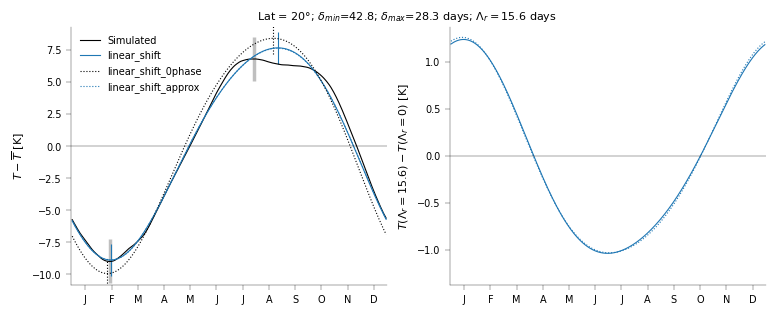

In [673]:
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)

ax[0].plot(ds.time, smooth_func(t_surf_anom[plot_lat_ind]), color='k', label='Simulated')
for key2 in ['linear_shift', 'linear_shift_0phase', 'linear_shift_approx']:
    ax[0].plot(ds.time, temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean(), color=color_approx[key2], 
                          linestyle=linestyle_approx[key2], label=key2)
    if '0phase' not in key2:
        ax[1].plot(ds.time, (temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean()) -
                   (temp_approx['linear_shift_0phase'][plot_lat_ind]-temp_approx['linear_shift_0phase'][plot_lat_ind].mean()),
                   color=color_approx[key2], linestyle=linestyle_approx[key2])
for key in time_extrema_sw:
    ax[0].scatter(time_extrema_temp[key]['simulated'][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key]['simulated'][plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
    for key2 in ['linear_shift', 'linear_shift_0phase']:
        ax[0].scatter(time_extrema_temp[key][key2][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key][key2][plot_lat_ind],
                           color=color_approx[key2], marker='|', s=500, linestyle=linestyle_approx[key2])
    
ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*month_ticks)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_ylim(-np.abs(ax[1].get_ylim()).max(), np.abs(ax[1].get_ylim()).max())
ax[0].set_ylabel('$T - \overline{T}$ [K]')
ax[1].set_ylabel(f'$T(\Lambda_r={round(lh_rh_cont_params[plot_lat_ind, -1], 1)}) - T(\Lambda_r= 0)$ [K]')
ax[0].legend()
fig.suptitle(f"Lat = ${int(ds.lat[plot_lat_ind])}\degree$; "
             f"$\delta_{'{min}'}$={round(time_extrema_temp['min']['simulated'][plot_lat_ind]-time_extrema_sw['min'], 1)}; "
             f"$\delta_{'{max}'}$={round(time_extrema_temp['max']['simulated'][plot_lat_ind]-time_extrema_sw['max'], 1)} days; "
             f"$\Lambda_r = {round(lh_rh_cont_params[plot_lat_ind, -1], 1)}$ days", fontsize=8, y=0.93);

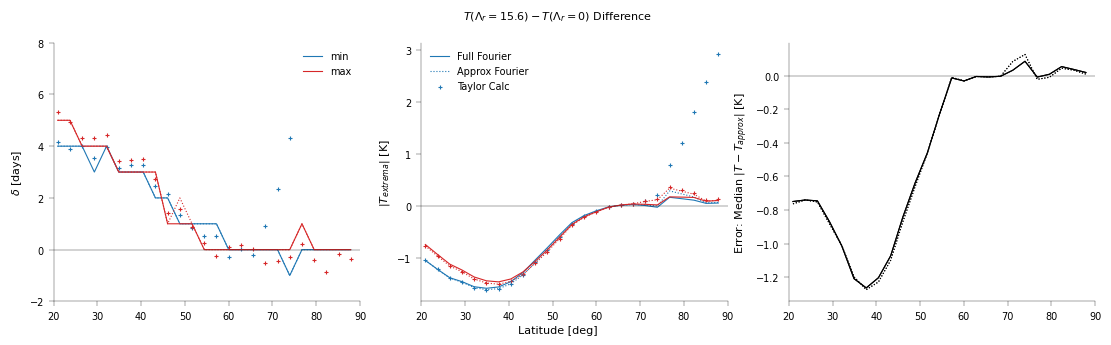

In [685]:
fig, ax = plt.subplots(1, 3, figsize=(im_sz*3*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['linear_shift', 'linear_shift_approx']:
        ax[0].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_temp[key]['linear_shift_0phase'], 
                   color=color_extrema[key], linestyle=linestyle_approx[key2], label=key if 'approx' not in key2 else None)
        ax[1].plot(ds.lat, amp_extrema_temp[key][key2] - amp_extrema_temp[key]['linear_shift_0phase'], 
                   color=color_extrema[key], linestyle=linestyle_approx[key2], label=f"{'Approx' if 'approx' in key2 else 'Full'} Fourier" if key=='min' else None)
        ax[2].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_approx[key2] - 
                                  np.mean(temp_approx[key2], axis=1)[:, np.newaxis]) - 
                   error_func(smooth_func(t_surf_anom), temp_approx['linear_shift_0phase'] - 
                                  np.mean(temp_approx['linear_shift_0phase'], axis=1)[:, np.newaxis]), 
                   color='k', linestyle=linestyle_approx[key2])
    ax[0].scatter(ds.lat, time_extrema_temp[key]['linear_shift_taylor_calc'] - time_extrema_temp[key]['linear_shift_0phase'], 
                   color=color_extrema[key], marker='+')
    ax[1].scatter(ds.lat, amp_extrema_temp[key]['linear_shift_taylor_calc'] - amp_extrema_temp[key]['linear_shift_0phase'], 
                   color=color_extrema[key], label='Taylor Calc' if key=='min' else None, marker='+')
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(ax_lims_lat)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$\delta$ [days]')
ax[1].set_ylabel('$|T_{extrema}|$ [K]')
ax[2].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [K]')
ax[0].set_ylim(-2, 8)
fig.supxlabel('Latitude [deg]', fontsize=8)
fig.suptitle(f'$T(\Lambda_r={round(lh_rh_cont_params[plot_lat_ind, -1], 1)}) - T(\Lambda_r= 0)$ Difference', fontsize=8);